## Interactive Notebook Template
Streamlining parameter scan to plot workflow.

### Start Up
1. Connect to the DAQ computer with a port opened (1234 just example): `ssh -L 1234:localhost:1234 <daq-computer>`
2. Launch jupyter notebook on that port: `jupyter-notebook --no-browser --port 1234`
3. Copy one of the URLs into your local browser.

### First Time
Needs jupyter notebook installed on the daq computer.
```
python3 -m pip install --upgrade notebook matplotlib uproot
```
*Tip*: Use `--user` if you don't have sudo rights.

In [79]:
import os
import subprocess
import tempfile

def pftool(cmds) :
    """Run the input list of commands through pftool
    
    Assumptions
    -----------
    - pftool is accessible to the shell (i.e. its in PATH)
    """
    with tempfile.NamedTemporaryFile() as fp :
        for c in cmds :
            fp.write(c)
        subprocess.run(f'pftool -s {fp.name}',shell=True,check=True)
    # python deletes tempfile when its object is deleted

def decode(fp, output='pd') :
    """Run singularity and decode the file at the input file path using the decoding script.
    
    Assumptions
    -----------
    - User is already in the ldmx environment (i.e. LDMX_BASE and LDMX_SINGULARITY_IMG are defined)
    - this function is running from the directory with 'decode.py' in it.
    - the ntuple file is put into this directory and is named 'adc_<raw_filename_no_extension>.root'
        (originally copied from decode.py)
    """
    if fp[0] == '~' :
        fp = os.environ['HOME']+fp[1:]
    fp = os.path.realpath(fp)
    base_name = os.path.basename(fp).replace('.raw','')
    dir_name  = os.path.realpath(os.path.dirname(fp))
    subprocess.run(['singularity',
                    'run',
                    '--no-home',
                    '--cleanenv',
                    '--env',
                    f'LDMX_BASE={os.environ["LDMX_BASE"]}',
                    '--bind', f'{os.environ["LDMX_BASE"]},{dir_name}',
                    f'{os.environ["LDMX_BASE"]}/{os.environ["LDMX_SINGULARITY_IMG"]}',
                    '.', 'fire', 'decode.py', fp],check=True)
    ntuples = f'adc_{base_name}.root'
    with uproot.open(ntuples) as f :
        data = f['ntuplizehgcroc/hgcroc'].arrays(library=output)
    return data

def scan_selections(df, param, min_val = 1, max_val = 5, step = 1, events_per_step = 100) :
    """Generate a dict of scan selections for the input dataframe and parameter
    
    Parameters
    ----------
    df : pandas.DataFrame
        dataframe with scan data in it
    param : str
        Name of parameter that was scanned
    min_val : int
        Minimum value parameter used
    max_val : int
        maximum value parameter was allowed to attain
    step : int
        step parameter was changed by while scanning
    events_per_step : int
        number of events data was taken for each value of parameter
    """
    return {
        f'{param} = {val}' : (df['event']>i*events_per_step)&(df['event']<=(i+1)*events_per_step)
        for i, val in enumerate(range(min_val,max_val+step,step))
    }

In [80]:
df = decode('~/ldmx/lund_8ts.raw')

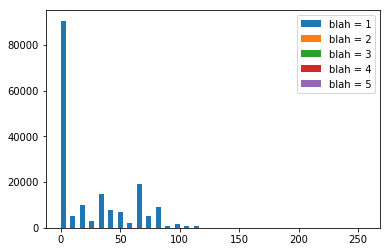

In [81]:
import matplotlib.pyplot as plt
for name, sl in scan_selections(df,'blah').items() :
    plt.hist(df[sl]['adc'],label=name,range=(0,256),bins=256//4)
plt.legend()
plt.show()

In [82]:
pftool([
    'status','exit'
])

TypeError: a bytes-like object is required, not 'str'